# Flight Control Design and Nonlinear Simulations of Closed-Loop System
### Raktim Bhattacharya
*Professor* 

Aerospace Engineering, Texas A&M University

raktim@tamu.edu, https://isrlab.github.io

**Note**: Plots will appear once the notebook is executed. May not show up in GitHub.

# Initialize

In [1]:
using F16Model 
using PrettyTables, LinearAlgebra, Plots, Convex, MosekTools, DifferentialEquations

F16Model.PrintStateAndControlBounds()

===== State Bounds =====
-Inf ≦ Npos (ft) ≦ Inf
-Inf ≦ Epos (ft) ≦ Inf
5000.0 ≦ h (ft) ≦ 40000.0
-1.5707963267948966 ≦ ϕ (rad) ≦ 1.5707963267948966
-1.5707963267948966 ≦ θ (rad) ≦ 1.5707963267948966
-1.5707963267948966 ≦ ψ (rad) ≦ 1.5707963267948966
300.0 ≦ V (ft/s) ≦ 900.0
-0.3490658503988659 ≦ α (rad) ≦ 0.7853981633974483
-0.5235987755982988 ≦ β (rad) ≦ 0.5235987755982988
-Inf ≦ p (rad/s) ≦ Inf
-Inf ≦ q (rad/s) ≦ Inf
-Inf ≦ r (rad/s) ≦ Inf
 
===== Control Bounds =====
1000.0 ≦ T (lbs) ≦ 19000.0
-25.0 ≦ δe (deg) ≦ 25.0
-21.5 ≦ δa (deg) ≦ 21.5
-30.0 ≦ δr (deg) ≦ 30.0
0.0 ≦ δlef (deg) ≦ 25.0


# Basic Operations

In [2]:
# Define state vector
# -------------------
d2r = pi/180;
npos = 0; # ft
epos = 0; # ft
alt = 10000; # should be in between 5000 ft and 100000 ft
phi = 0;   # rad -- Roll
theta = 0; # rad -- Pitch
psi = 0;   # rad -- Yaw
Vt = 300;  # ft/s -- Total velocity
alp = 0;   # rad -- Angle of attack
bet = 0;   # rad -- Side slip angle 
p = 0;     # rad/s -- Roll rate
q = 0;     # rad/s -- Pitch rate
r = 0;     # rad/s -- Yaw rate

x0 = [npos,epos,alt,phi,theta,psi,Vt,alp,bet,p,q,r];

# Define control vector
# ---------------------
T = 9000; # Thrust lbs
dele = 0; # deg elevator angle
dail = 0; # deg aileron angle
drud = 0; # deg rudder angle
dlef = 0; # deg leading edge flap angle
u0 = [T,dele,dail,drud,dlef];

In [3]:
# Evaluate xdot -- inplace implementation -- use this with DifferentialEquations package.
xdot1 = zeros(12);
F16Model.Dynamics!(xdot1,x0,u0); # Does not implement actuator dynamics.

# Evaluate xdot -- returns vector. Use this for linearization of dynamics, etc.
xdot2 = F16Model.Dynamics(x0,u0); #  Does not implement actuator dynamics.

# Find Equilibrium (or Trim) Condition
For steady-level flight.

In [4]:
# Trim the aircraft for steady-level flight at h0,V0
# xbar = trim state
# ubar = trim control
# status = status of the optimization, status = 0 means optimization found solution and (xbar, ubar) defines a valid trim  point
# prob = data structure from IpOpt.

h0 = 10000; # ft
Vt0 = 500;   # ft/s

# Stead-Level Flight
xbar, ubar, status, prob = F16Model.Trim(h0,Vt0,γ=0, ψdot=0, ϕ=(0,1), ψ=(0,1), β=(0,1), p=(0,1), q=(0,1), r=(0,1));
xdot_trim = F16Model.Dynamics(xbar,ubar); # Should be close to zero.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:        8
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

# Check Trim Values

In [5]:
# Check Trim Values
xuBounds = F16Model.StateAndControlBounds();
states = ["npos","epos","h","phi","theta","psi","V","alpha","beta","p","q","r"];
statesDer = ["Dnpos","Depos","Dh","Dphi","Dtheta","Dpsi","DV","Dalpha","Ddbeta","Dp","Dq","Dr"];
controls = ["T","ele","ail","rud","lef"];

xmin = vcat([-Inf;-Inf],xuBounds[1:10,1]); xmax = vcat([Inf;Inf], xuBounds[1:10,2]);

data = hcat(states,xdot_trim,xmin,xbar,xmax)
pretty_table(header=["states","xdot","xmin","xbar","xmax"],data);
pretty_table(header=["controls","umin","ubar","umax"],hcat(controls,xuBounds[11:end,1],ubar,xuBounds[11:end,2]));

┌────────┬──────────────┬───────────┬───────────┬──────────┐
│ states │         xdot │      xmin │      xbar │     xmax │
├────────┼──────────────┼───────────┼───────────┼──────────┤
│   npos │        500.0 │      -Inf │       0.0 │      Inf │
│   epos │          0.0 │      -Inf │       0.0 │      Inf │
│      h │   3.02269e-5 │    5000.0 │   10000.0 │  40000.0 │
│    phi │          0.0 │   -1.5708 │       0.0 │   1.5708 │
│  theta │          0.0 │   -1.5708 │ 0.0590342 │   1.5708 │
│    psi │          0.0 │   -1.5708 │       0.0 │   1.5708 │
│      V │   1.89432e-9 │     300.0 │     500.0 │    900.0 │
│  alpha │   8.79867e-6 │ -0.349066 │ 0.0590341 │ 0.785398 │
│   beta │ -0.000701234 │ -0.523599 │       0.0 │ 0.523599 │
│      p │   6.75021e-8 │      -Inf │       0.0 │      Inf │
│      q │  -2.15363e-7 │      -Inf │       0.0 │      Inf │
│      r │  -9.08611e-6 │      -Inf │       0.0 │      Inf │
└────────┴──────────────┴───────────┴───────────┴──────────┘
┌──────────┬────────┬───

# Linear Analysis

┌───────────┬─────────────┬──────────────┬───────────┬──────────┬────────────┬─────────────┐
│ xdotLongi │       theta │            V │     alpha │        q │          T │         ele │
├───────────┼─────────────┼──────────────┼───────────┼──────────┼────────────┼─────────────┤
│    Dtheta │         0.0 │          0.0 │       0.0 │      1.0 │        0.0 │         0.0 │
│        DV │      -32.17 │   -0.0118591 │  -2.58453 │ -1.28295 │ 0.00156727 │   0.0662367 │
│    Dalpha │ -3.88959e-9 │ -0.000255941 │ -0.782055 │ 0.929171 │ -1.8526e-7 │ -0.00172694 │
│        Dq │         0.0 │ -8.61453e-10 │ -0.455764 │ -1.01533 │        0.0 │   -0.140354 │
└───────────┴─────────────┴──────────────┴───────────┴──────────┴────────────┴─────────────┘
┌─────────────────────────┐
│            Eigen values │
├─────────────────────────┤
│    -0.901194-0.640782im │
│    -0.901194+0.640782im │
│ -0.00342886-0.0552919im │
│ -0.00342886+0.0552919im │
└─────────────────────────┘


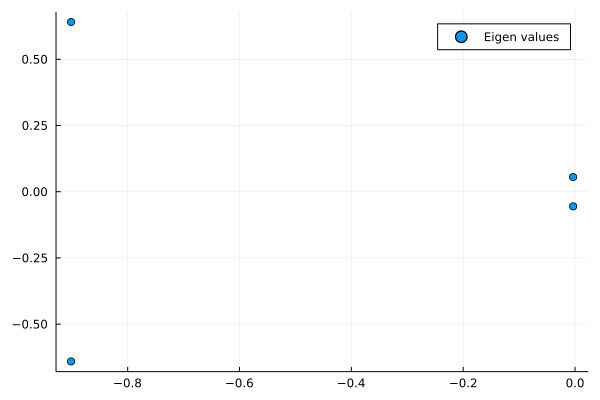

In [6]:
# Linearize about trim point (xbar,ubar)
A, B = F16Model.Linearize(xbar,ubar);

# Pull out longitudinal dynamics -- states:(theta,V,alpha,q), control:(T,ele)
ix = [5,7,8,11]; iu = [1,2]; # 4 states, 3 control system.
longiA = A[ix,ix];
longiB = B[ix,iu];

# Show system
pretty_table(header = vcat("xdotLongi",states[ix],controls[iu]),hcat(statesDer[ix],longiA,longiB))

# Eigen values 
ev = eigen(longiA).values;
pretty_table(header=["Eigen values"],ev)

plot(real(ev),imag(ev),seriestype=:scatter,label="Eigen values")

# Linear Controller Design
Design state feedback controller $$u = Kx,$$ for the system $$\dot{x}(t) = Ax(t) + Bu(t),$$
which minimizes the cost
$$
\int_0^\infty \left(x^TQx + u^TRu\right)dt.
$$
Can be solved as the following convex optimization problem. See pg. 28 in [this document](https://isrlab.github.io/pdfs/aero632/05a%20StateFeedback%20LQR.pdf).

In [7]:
# Design LQR 
Q = Diagonal([1/0.1,1/100,1/0.1,1/200]);
R = Diagonal([1/5000,1/5]);

ns,nu = size(longiB);
Y = Semidefinite(ns,ns);
W = Convex.Variable(nu,ns)

M11 = (longiA*Y + longiB*W) + (longiA*Y + longiB*W)'
M = [M11 Y W';
     Y  -inv(Q) zeros(ns,nu);
     W   zeros(nu,ns) -inv(R)];
prob = maximize(tr(Y),-M in :SDP)

Convex.solve!(prob,Mosek.Optimizer); # Careful with other solvers. Solution accuracy impacts controller performance.
@show prob.status

MOSEK warning 500: The license expires in 5 days.
MOSEK warning 500: The license expires in 5 days.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 117             
  Cones                  : 0               
  Scalar variables       : 25              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 5
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 12              
Pr

OPTIMAL::TerminationStatusCode = 1

┌─────────────────────────┬──────────────────────┐
│                   OL EV │                CL EV │
├─────────────────────────┼──────────────────────┤
│    -0.901194-0.640782im │ -0.959344-0.898536im │
│    -0.901194+0.640782im │ -0.959344+0.898536im │
│ -0.00342886-0.0552919im │ -0.608212-0.289656im │
│ -0.00342886+0.0552919im │ -0.608212+0.289656im │
└─────────────────────────┴──────────────────────┘


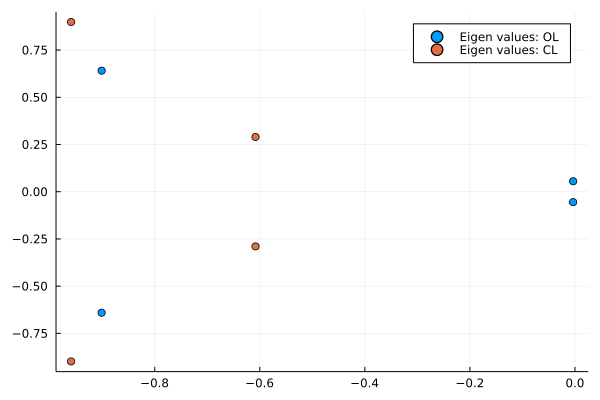

In [8]:
# Closed-loop linear system
K = W.value*inv(Y.value); # Recover controller gain.
Acl = longiA + longiB*K;  # Closed-loop system.

# Eigen values 
ev_cl = eigen(Acl).values;
pretty_table(header=["OL EV","CL EV"],hcat(ev,ev_cl));

plot(real(ev),imag(ev),seriestype=:scatter,label="Eigen values: OL")
plot!(real(ev_cl),imag(ev_cl),seriestype=:scatter,label="Eigen values: CL")

We see from the above plot that the closed-loop system has improved the low frequency lightly damped modes (known as phugoid mode). This is reflected in faster decay of perturbations as shown next.

# Simulate Linear System with LQR 

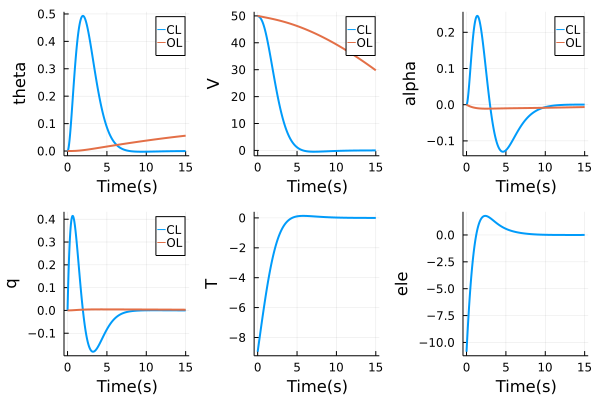

In [9]:
# Simulate linear system
dt = 0.01; tfinal = 15;
tGrid = 0:dt:tfinal;

x0 = [0,50,0,0];

xTraj = hcat([exp(Acl*t)*x0 for t in tGrid]...);
xTrajOL = hcat([exp(longiA*t)*x0 for t in tGrid]...);
xp = [plot(tGrid,[xTraj[i,:],xTrajOL[i,:]],label=["CL" "OL"],xlabel="Time(s)",ylabel=states[ix[i]],lw=2) for i in 1:ns]

uTraj = K*xTraj;
up = [plot(tGrid,uTraj[i,:],label=:none,xlabel="Time(s)",ylabel=controls[iu[i]],lw=2) for i in 1:nu]

display(plot(xp...,up...));

# Simulate Nonlinear Closed-Loop System

In [10]:
# Create nonlinear closed-loop system 
function nonlinear_longi_F16_cl!(xdot,x,p,t)
    xpert = x-xbar;
    u = copy(ubar);
    u[iu] = K*xpert[ix];
    F16Model.Dynamics!(xdot,x,u);
end

# Simulate from some initial condition: 50 ft/s perturbation from trim.
nl_x0 =  xbar + [0,0,0,0,0,0,50,0,0,0,0,0]; # IC is offset from trim.
tspan = (0.0,30);
xdot = zeros(12)
prob = ODEProblem(nonlinear_longi_F16_cl!,nl_x0,tspan);
sol = solve(prob);

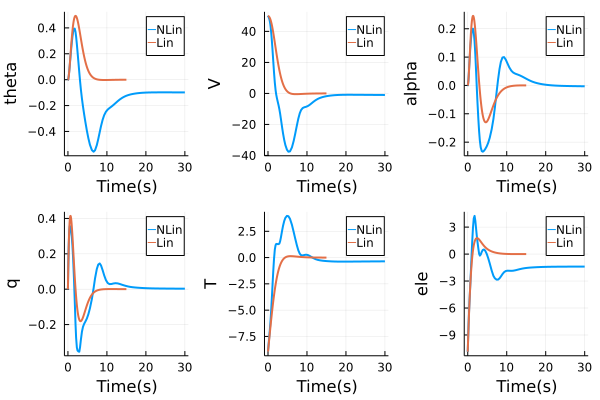

In [11]:
# Plot the nonlinear solution and compare with linear solution.
xTrajNL = hcat(sol.u...);
xpert = xTrajNL .- xbar;
uNL = K*xpert[ix,:]; 


xpNL = [begin 
        plot(sol.t,sol[ix[i],:].-xbar[ix[i]],label="NLin",lw=2,xlabel="Time(s)",ylabel=states[ix[i]]); 
        plot!(tGrid,xTraj[i,:],label="Lin",lw=2);
     end for i in 1:ns];

upNL = [begin 
     plot(sol.t,uNL[i,:],label="NLin",lw=2,xlabel="Time(s)",ylabel=controls[iu[i]]); 
     plot!(tGrid,uTraj[i,:],label="Lin",lw=2);
  end for i in 1:nu];

display(plot(xpNL...,upNL...));

# Large perturbation
Simulate with velocity perturbation equal to 110 ft/s. 

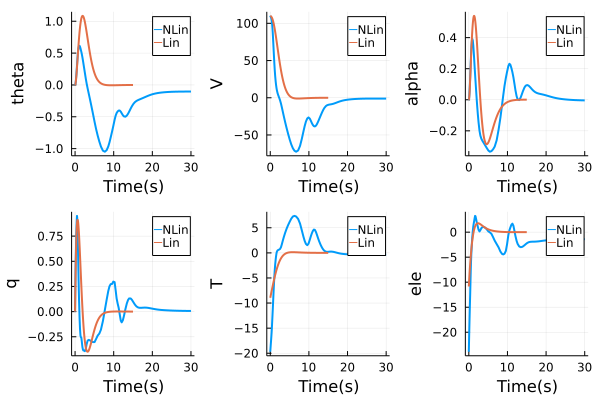

In [12]:
nl_x0 =  xbar + [0,0,0,0,0,0,110,0,0,0,0,0]; # IC is offset from trim.
tspan = (0.0,30);
xdot = zeros(12)
prob = ODEProblem(nonlinear_longi_F16_cl!,nl_x0,tspan);
sol = solve(prob);

xTrajNL = hcat(sol.u...);
xpert = xTrajNL .- xbar; #K*xpert[ix];
uNL = K*xpert[ix,:]; 

x0 = [0,110,0,0];
xTraj = hcat([exp(Acl*t)*x0 for t in tGrid]...);

xpNL = [begin 
        plot(sol.t,sol[ix[i],:].-xbar[ix[i]],label="NLin",lw=2,xlabel="Time(s)",ylabel=states[ix[i]]); 
        plot!(tGrid,xTraj[i,:],label="Lin",lw=2);
     end for i in 1:ns];

upNL = [begin 
     plot(sol.t,uNL[i,:],label="NLin",lw=2,xlabel="Time(s)",ylabel=controls[iu[i]]); 
     plot!(tGrid,uTraj[i,:],label="Lin",lw=2);
  end for i in 1:nu];

display(plot(xpNL...,upNL...));